In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV, train_test_split

ruta_csv = 'combined_statistics_full.csv'
df = pd.read_csv(ruta_csv)

X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()
#X = X.astype(float)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


svc_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10]
}

svc = SVC()

grid_svc = GridSearchCV(
    estimator=svc,
    param_grid=svc_params,
    cv=5,
    scoring='accuracy',
    verbose=1
)

print("Ajustando SVC...")
grid_svc.fit(X_train_scaled, y_train)

print(f"Mejores hiperparámetros SVC: {grid_svc.best_params_}")
print(f"Mejor precisión SVC: {grid_svc.best_score_:.4f}")

Ajustando SVC...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Mejores hiperparámetros SVC: {'C': 100, 'gamma': 0.01}
Mejor precisión SVC: 0.7269



Model Information:
Number of support vectors: 1218
Training accuracy: 0.998
Test accuracy: 0.711


C:\Users\hodei\AppData\Local\Temp\ipykernel_2220\2690965566.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


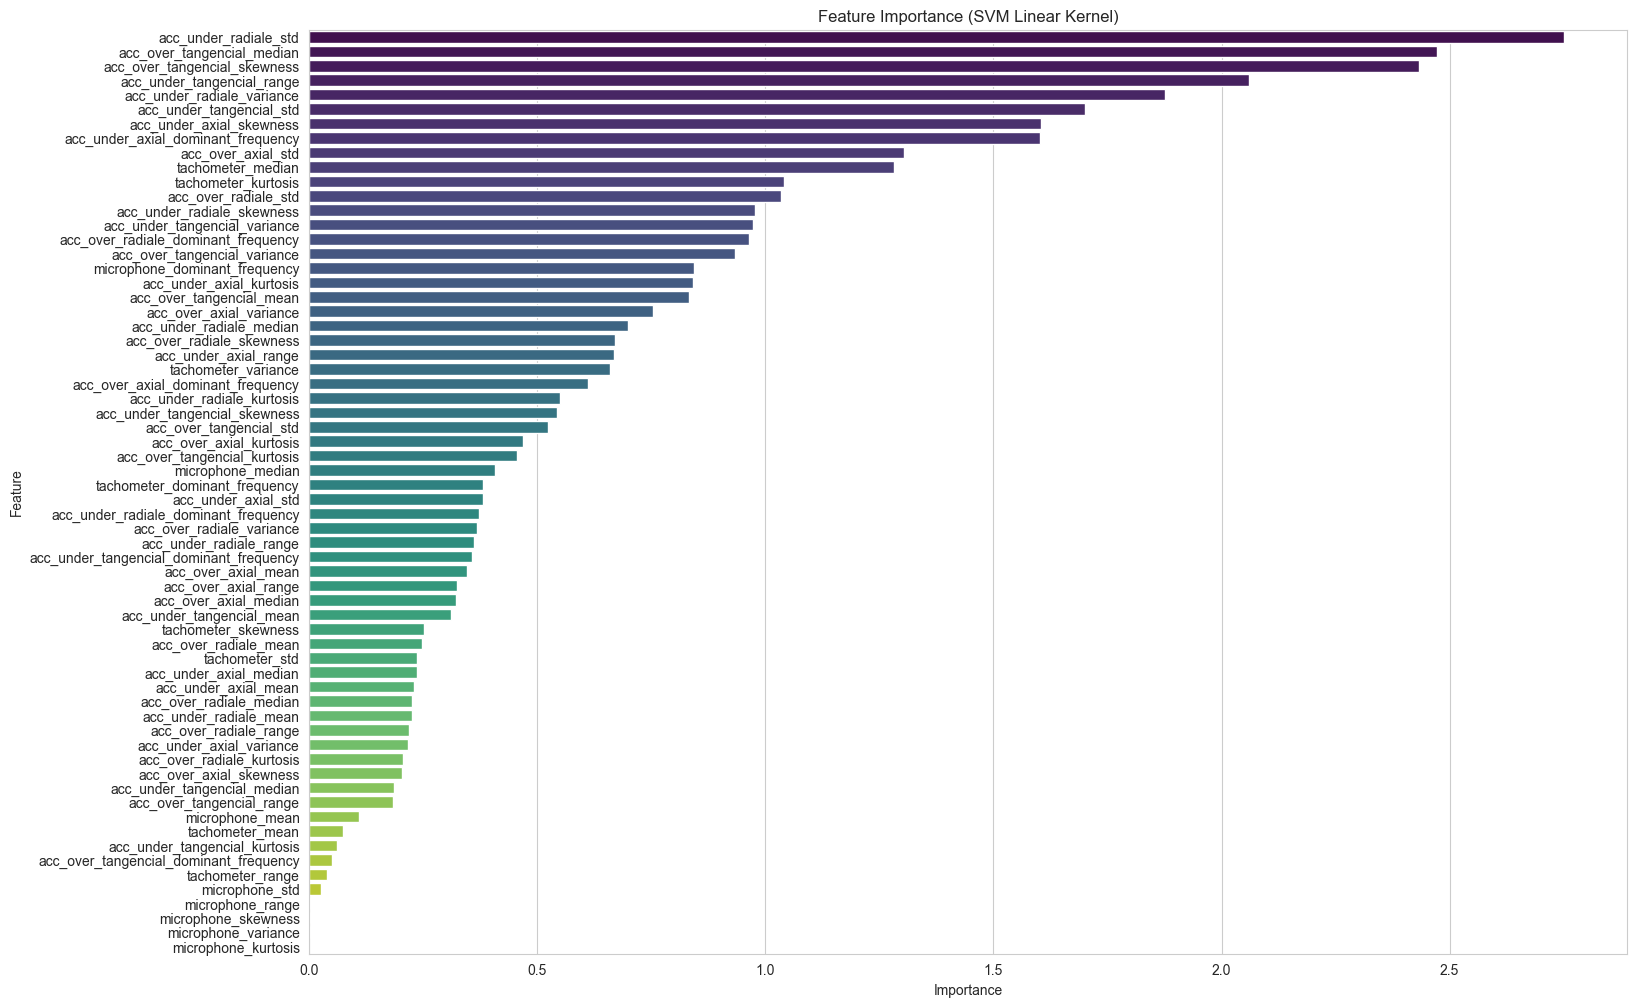

In [33]:
svm_basic = SVC(kernel='linear', probability=True, random_state=42, C=100, gamma=0.01)
svm_basic.fit(X_train_scaled, y_train)


print("\nModel Information:")
print(f"Number of support vectors: {len(svm_basic.support_vectors_)}")
print(f"Training accuracy: {svm_basic.score(X_train_scaled, y_train):.3f}")
print(f"Test accuracy: {svm_basic.score(X_test_scaled, y_test):.3f}")

coef_importance = abs(svm_basic.coef_[0])
feature_names = df.iloc[:,:-1].columns


importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': coef_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(17, 12))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance (SVM Linear Kernel)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [37]:
total_importance = importance_df['Importance'].sum()
# print(total_importance) --> efektibamente da 1

cumulative_importance = importance_df['Importance'].cumsum()
selected_features = importance_df[cumulative_importance <= total_importance * 0.9] #cogemos el 90% de la importancia

print("\nSelected Features (90% of importance):")
print(selected_features)


Selected Features (90% of importance):
                                    Feature  Importance
18                    acc_under_radiale_std    2.751359
49               acc_over_tangencial_median    2.472126
53             acc_over_tangencial_skewness    2.431973
28               acc_under_tangencial_range    2.059554
19               acc_under_radiale_variance    1.876483
26                 acc_under_tangencial_std    1.700784
13                 acc_under_axial_skewness    1.604822
15       acc_under_axial_dominant_frequency    1.602483
34                       acc_over_axial_std    1.303567
1                         tachometer_median    1.281903
6                       tachometer_kurtosis    1.040569
42                     acc_over_radiale_std    1.035096
21               acc_under_radiale_skewness    0.976514
27            acc_under_tangencial_variance    0.973225
47      acc_over_radiale_dominant_frequency    0.962847
51             acc_over_tangencial_variance    0.933263
63      

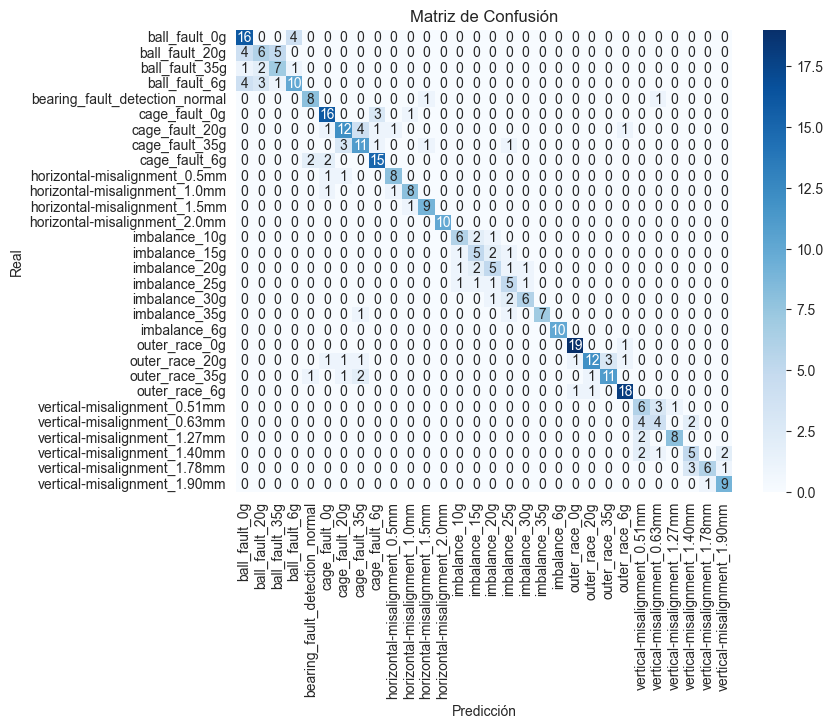

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

rf_test_pred = svm_basic.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, rf_test_pred)

classes = sorted(set(y_test))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

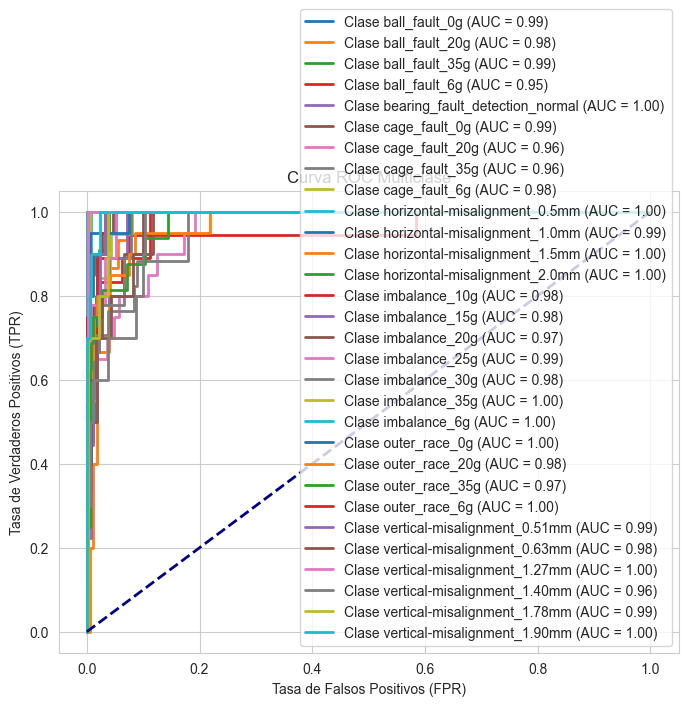

In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=classes)
rf_test_prob = svm_basic.predict_proba(X_test_scaled)

plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Clase {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Multiclase')
plt.legend(loc='lower right')
plt.show()
